In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import tensorflow as tf
import numpy as np
from ray.experimental.tfutils import TensorFlowVariables

/anaconda3/envs/flow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda3/envs/flow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [76]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1600px;height:750px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [4]:
A = np.array([[1.001, 0], [0, 0.5]])
B = np.array([[1.], [1.]])

# for controllability
cont = np.hstack([B, A@B, A@A@B])
assert np.linalg.matrix_rank(cont)==cont.shape[0]

In [5]:
x0 = np.array([[1.], [1.]])  # 2x1 vector 

A = tf.constant(np.array([[1.001, 0], [0, -0.6]]), dtype=tf.float32, name='A')  # system dynamics
B = tf.constant(np.array([[1.], [1.]]), dtype=tf.float32, name='B')

Q = tf.constant([[1.,0.], [0.,1.]], name='Q')  # weighting
R = tf.constant(1., name='R')

x = tf.constant(x0, dtype=tf.float32, name="state")

T = 10

In [6]:
####### Defining network #######
# input: state x
# output: control u

input_layer = tf.placeholder(tf.float32, (None,2), name='in_layer')
fc1 = tf.layers.dense(inputs=input_layer, units=1, activation=tf.nn.tanh, name='fc1', reuse=tf.AUTO_REUSE)
u = tf.layers.dense(inputs=fc1, units=1, activation=tf.nn.tanh, name='fc_out', reuse=tf.AUTO_REUSE)
# u = tf.layers.dense(inputs=input_layer, units=1, name='u_out_layer', reuse=tf.AUTO_REUSE)

### LOSS FUNCTION ### 
loss = tf.add(tf.matmul(tf.matmul(tf.transpose(x), Q), x), 
              tf.matmul(tf.transpose(u), tf.multiply(R, u)), name='loss')

# xs = tf.identity(x, name='xs')
# us = tf.constant(0, name='us')
xs = x
us = u

# cond = lambda i, x, l, xs, us: i < T

# def body(i, x, l, xs, us):
#     next_i = i+1
#     next_x = tf.add(tf.matmul(A, x), tf.multiply(u,B))
#     next_l = tf.add(l,
#                     tf.add(tf.matmul(tf.matmul(tf.transpose(x), Q), x),
#                            tf.matmul(tf.transpose(u), tf.multiply(R, u))))
#     next_xs = tf.concat(xs, next_x)
#     next_us = tf.concat(us, u)
#     return (next_i, next_x, next_l, next_xs, next_us)

# i, xloss_f, traj_f = tf.while_loop(cond, body, 
#                                    loop_vars=[tf.constant(0), x, loss, xs, us],
#                                    shape_invariants=[tf.TensorShape([1,]), tf.TensorShape([2, 1]), 
#                                                      tf.TensorShape([1,]) , tf.TensorShape([2, None]), 
#                                                      tf.TensorShape([1, None])])
# train = tf.train.GradientDescentOptimizer(0.01).minimize(xloss_f.loss)

for i in range(T):
    # LQR loss 
#     x_term = tf.matmul(tf.matmul(tf.transpose(x), Q), x, name='x_term')
#     u_term = tf.matmul(tf.transpose(u), tf.multiply(R, u), name='u_term')
#     loss = tf.add(loss, tf.add(x_term, u_term), name='loss')  # accumulate loss
    
    # Dynamics: advancing the system dynamics
    Ax = tf.matmul(A, x, name='Ax'+str(i))
    Bu = tf.multiply(u, B, name='Bu'+str(i))  # tf.multiply because u is a scalar
    x = tf.add(Ax, Bu, name='state'+str(i))  # next state vector

    loss = tf.add(loss, tf.add(tf.matmul(tf.matmul(tf.transpose(x), Q), x), tf.matmul(tf.transpose(u), tf.multiply(R, u))), name='loss'+str(i))  # accumulate loss    
    
#     u = tf.layers.dense(inputs=tf.transpose(x), units=1, name='u_out_layer', reuse=True)
    
    fc1 = tf.layers.dense(inputs=tf.transpose(x), units=1, name='fc1', reuse=True)
    u = tf.layers.dense(inputs=fc1, units=1, name='fc_out', reuse=True)
    
    xs = tf.concat([xs, x], 1)
    us = tf.concat([us, u], 1)
    
opt = tf.train.GradientDescentOptimizer(0.0001)
train = opt.minimize(loss)
grads_and_vars = opt.compute_gradients(loss)

In [7]:
# show_graph(tf.get_default_graph().as_graph_def())

In [8]:
# new_weights = v[-1]['weights'].copy()
# new_weights['u_out_layer/bias'] = new_weights.pop('fc1/biases')
# new_weights['u_out_layer/kernel'] = new_weights.pop('fc1/weights')
# del new_weights['fc_out/biases']
# del new_weights['fc_out/weights']
# new_weights

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        sess.run(train, feed_dict={input_layer : x0.T})
        if i % 100 == 0:
            results = sess.run([xs, us, loss], feed_dict={input_layer : x0.T})
            labels  = "xs us loss".split(' ')
            print('training iteration', i)
            for label,result in zip(*(labels,results)) :
                print(label)
                print(result)
                print('')
            print('gradients')
            for g, v in grads_and_vars:
                print(str(sess.run(g, feed_dict={input_layer : x0.T})) + " - " + v.name)
            print('----------------------')

training iteration 0
xs
[[ 1.          1.0531694   1.0574822   1.1169957   1.1529142   1.2085396
   1.2611325   1.3237815   1.390256    1.4648727   1.5463333 ]
 [ 1.         -0.54783064  0.331958   -0.14071882  0.11923278 -0.01706719
   0.06162465  0.02441302  0.05050296  0.04292452  0.05424096]]

us
[[0.05216937 0.00325961 0.058456   0.03480149 0.05447248 0.05138434
  0.06138781 0.06515077 0.07322629 0.07999568 0.0886057 ]]

loss
[[18.569374]]

gradients
[[-30.89964   ]
 [ -0.72742486]] - fc1/kernel:0
[-27.211784] - fc1/bias:0
[[-159.53268]] - fc_out/kernel:0
[214.51302] - fc_out/bias:0
----------------------
training iteration 100
xs
[[ 1.          0.89100224  0.75377876  0.63418704  0.49726033  0.36295062
   0.21946104  0.07333399 -0.07949694 -0.23697719 -0.40060037]
 [ 1.         -0.70999783  0.2878842  -0.29307607  0.03828476 -0.15777783
  -0.04918584 -0.11683501 -0.08280326 -0.1077188  -0.09875493]]

us
[[-0.1099978  -0.13811451 -0.12034553 -0.13756089 -0.13480698 -0.14385255
  -

## compute optimal loss with true LQR ricatti equation formulation

In [11]:
import controlpy

In [12]:
with tf.Session() as sess:
    A_np, B_np, Q_np, R_np = sess.run([A, B, Q, R])

K, P, eig = controlpy.synthesis.controller_lqr_discrete_time(A_np, B_np, Q_np, R_np)
x_np = x0
u_np = (-K@x_np)
xs_np, us_np = np.array(x_np), np.array(u_np)
loss_np = 0
for i in range(T):
    loss_np += x_np.T@Q_np@x_np + u_np.T*R_np*u_np
    x_np = A_np@x_np + B_np@u_np
    u_np = (-K@x_np)
    xs_np = np.hstack([xs_np, x_np])
    us_np = np.hstack([us_np, u_np])

In [13]:
loss_np

array([[3.71948966]])

## Pulling iter_vars

In [14]:
import pickle

In [121]:
# result_dir = '/Users/nishant/ray_results/2018-08-26_22-43-29r4a9tt7u'
result_dir = '/Users/nishant/ray_results/2018-08-28_22-18-1581dc8109'
fname = result_dir + '/iter_vars.pkl'
with open(fname, 'rb') as file:
    itervars = pickle.load(file)

In [124]:
grads = [np.array(iteration['grad']) for iteration in itervars]
for grad in grads:
    print('variance:\n', np.var(grad, 0))
    print('covariance:\n', np.cov(grad.T), '\n')

variance:
 [0.01450538 0.01164358 0.00654571 0.0145029  0.00610316]
covariance:
 [[ 0.01526883  0.00455985  0.00055795 -0.00244075  0.00012395]
 [ 0.00455985  0.0122564  -0.00079345 -0.00110888  0.00061164]
 [ 0.00055795 -0.00079345  0.00689022  0.00166534 -0.00090891]
 [-0.00244075 -0.00110888  0.00166534  0.01526621 -0.00428887]
 [ 0.00012395  0.00061164 -0.00090891 -0.00428887  0.00642438]] 

variance:
 [0.02445795 0.00998329 0.00601458 0.00713453 0.00357143]
covariance:
 [[ 0.02574521 -0.00306064  0.00079332 -0.00648588  0.00280767]
 [-0.00306064  0.01050873 -0.00226477  0.00011572 -0.00175403]
 [ 0.00079332 -0.00226477  0.00633114  0.00128353  0.0013744 ]
 [-0.00648588  0.00011572  0.00128353  0.00751003 -0.00114397]
 [ 0.00280767 -0.00175403  0.0013744  -0.00114397  0.0037594 ]] 

variance:
 [0.00623509 0.01028117 0.00592241 0.01625676 0.00335484]
covariance:
 [[ 0.00656325  0.00020535 -0.00103362  0.00171805 -0.00155056]
 [ 0.00020535  0.01082228 -0.00111497 -0.00368746 -0.00132

In [45]:
# policy.variables.set_flat(np.arange(policy.variables.get_flat_size())) yields:
# {'fc1/weights':    array([[0.],
#                           [1.]], dtype=float32), 
#  'fc1/biases':      array([2.], dtype=float32), 
#  'fc_out/weights': array([[3.]], dtype=float32), 
#  'fc_out/biases':   array([4.], dtype=float32)}

In [80]:
def eval_grads(new_weights):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    variables = TensorFlowVariables(loss, sess)
    variables.set_weights(new_weights)
    grads = {}
    for g, v in grads_and_vars:
        grads[v.name] = sess.run(g, feed_dict={input_layer : x0.T})
        # print(str(sess.run(g, feed_dict={input_layer : x0.T})) + " - " + v.name)
    sess.close()
    return grads

def process_weights(w):
    nw = dict()
    nw['fc1/kernel'] = w['fc1/weights']
    nw['fc1/bias'] = w['fc1/biases']
    nw['fc_out/kernel'] = w['fc_out/weights']
    nw['fc_out/bias'] = w['fc_out/biases']
    return nw        

def flatten_grads(g):
    arr = np.array([])
    arr = np.append(arr, g['fc1/kernel:0'])  # weights
    arr = np.append(arr, g['fc1/bias:0'])
    arr = np.append(arr, g['fc_out/kernel:0'])  # weights
    arr = np.append(arr, g['fc_out/bias:0'])
    return arr

def full(iteration):
    true_grad = flatten_grads(eval_grads(process_weights(iteration['weights'])))
    return np.corrcoef(true_grad, iteration['grad'])

In [91]:
#corrs = [full(iteration)[1,0] for iteration in itervars]
corrs[:10]

[-0.9938537864983251,
 -0.9988271066087063,
 -0.9933170092601875,
 -0.9957520060895376,
 -0.99692332942902,
 -0.9929723307833618,
 -0.6769708355951042,
 -0.08730229730588654,
 -0.8557576890538137,
 -0.6330676199322628]

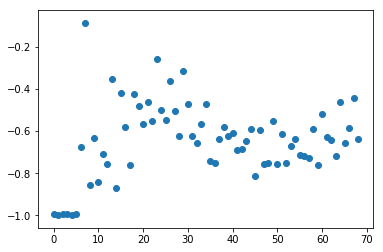

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(np.arange(len(corrs)), corrs)
plt.show()

In [90]:
import pandas as pd
with open('/Users/nishant/ray_results/2018-08-26_22-43-29r4a9tt7u/progress.csv', 'rb') as file:
    prog = pd.read_csv(file)
prog

EmptyDataError: No columns to parse from file

In [39]:
for iteration in itervars:
    print(eval_grads(process_weights(iteration['weights'])))

{'fc1/bias:0': array([1.5390728], dtype=float32), 'fc_out/kernel:0': array([[-61.29186]], dtype=float32), 'fc_out/bias:0': array([78.44572], dtype=float32), 'fc1/kernel:0': array([[ 1.3710754 ],
       [-0.10271908]], dtype=float32)}
{'fc1/bias:0': array([1.7677462], dtype=float32), 'fc_out/kernel:0': array([[-43.78142]], dtype=float32), 'fc_out/bias:0': array([61.0312], dtype=float32), 'fc1/kernel:0': array([[ 1.4524152 ],
       [-0.15942253]], dtype=float32)}
{'fc1/bias:0': array([1.6559447], dtype=float32), 'fc_out/kernel:0': array([[-29.626226]], dtype=float32), 'fc_out/bias:0': array([44.950897], dtype=float32), 'fc1/kernel:0': array([[ 1.2619764 ],
       [-0.19968915]], dtype=float32)}
{'fc1/bias:0': array([1.3879302], dtype=float32), 'fc_out/kernel:0': array([[-19.05171]], dtype=float32), 'fc_out/bias:0': array([30.772741], dtype=float32), 'fc1/kernel:0': array([[ 1.011159  ],
       [-0.22799984]], dtype=float32)}
{'fc1/bias:0': array([0.95035666], dtype=float32), 'fc_out/ker